In [1]:
from sqlalchemy import create_engine
import time
from datetime import timedelta, date, datetime
import numpy as np
import pandas as pd
import warnings
import pandas as pd
from fbprophet import Prophet
warnings.simplefilter('ignore')
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv
Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv


In [3]:
df1=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True,dayfirst=True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True,dayfirst=True)


df1 = df1.loc['2017-01-01':'2022-02-28']
df2 = df2.loc['2017-01-01':'2022-02-28']

index = pd.date_range(start='2017-01-01', end='2022-02-28', freq="1d")
columns = ["datetime_per_month", 'Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA','Electricity Consumption (MWh)']

df = pd.DataFrame(np.nan, index=range(0,index.size), columns=columns)
df["datetime_per_month"] = index
df.set_index("datetime_per_month", inplace=True)

df = df.resample("M").mean()


columns1 = ['Electricity Consumption (MWh)']
for column in columns1 : 
    df[column] = df2[column].resample("M").sum()
columns2=['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns2 : 
    df[column] = df2[column].resample("M").mean()
df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(13):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()


In [4]:
df = df.reset_index(level=0)
df = df[["Price - PT [€/MWh]", "datetime_per_month"]]
df.columns = ['y', 'ds']
df

,y,ds
0,51.430655,2017-02-28
1,43.956841,2017-03-31
2,44.178000,2017-04-30
3,47.121747,2017-05-31
4,50.220153,2017-06-30
5,48.604099,2017-07-31
6,47.434825,2017-08-31
7,49.161833,2017-09-30
8,56.979099,2017-10-31
9,59.338500,2017-11-30


In [5]:
# split into train and test sets 
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]

m = Prophet(interval_width=0.95)
start_time = time.time()
model = m.fit(train)
exec_time = time.time()-start_time

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


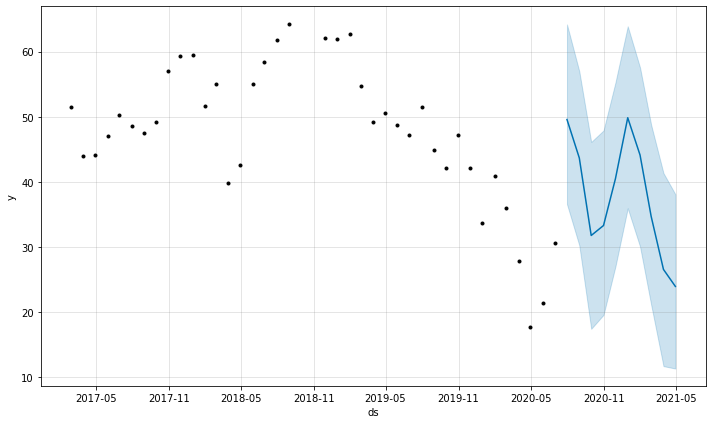

In [6]:
forecast = m.predict(test)
plot1 = m.plot(forecast)

In [7]:
inv_y = test['y']
inv_yhat = forecast['yhat']

#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('Execution Time:', '%.5f' %  exec_time)

Mean Absolute Error: 12.81731895717005
Mean Squared Error: 280.8868583321311
Root Mean Squared Error: 16.759679541450996
Coefficient of Variance: 38.7569936205475
R2: -1.369482233439462
Execution Time: 0.37539


[Text(0, 0.5, 'Price [€/MWh]'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, "Prix de l'éléctricité au Portugal")]

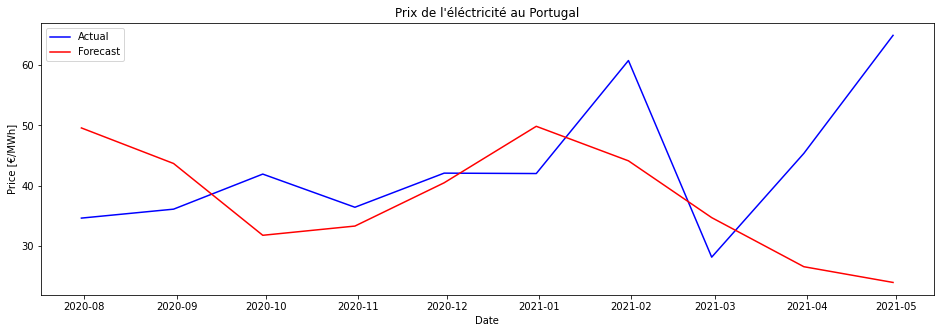

In [8]:
plt.figure(figsize=(16,5))
plt.plot(test['ds'], inv_y, color='blue')
plt.plot(test['ds'], inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Price [€/MWh]')